In [295]:
# Standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from pandas import read_csv
import time
sns.set(style='whitegrid', palette='muted')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

# Sklearn
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

from sklearn.cluster import KMeans
from scipy.stats import uniform

from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import xgboost as xgb

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [296]:
import project_helper
import importlib
importlib.reload(project_helper)

<module 'project_helper' from '/Users/brandonng/Downloads/Predicting-US-Bankruptcy/project_helper.py'>

Best model is defined as the model that is low in complexity (high in regularization) and yet yields a good result according to the objective function

How to interpret scoring: first value is the average of objective function across all folds in walk forward validation, estimating the test set objective function value, second is the standard error of the statistic across folds

# Data loading and preprocessing

In [297]:
# Load and process data
bankruptcy_df = pd.read_excel('US Bankruptcy Dataset.xlsx', sheet_name=2)
print(bankruptcy_df.head())

  company_name status_label  year       X1       X2      X3      X4       X5   
0          C_1        alive  1999  511.267  833.107  18.373  89.031  336.018  \
1          C_1        alive  2000  485.856  713.811  18.577  64.367  320.590   
2          C_1        alive  2001  436.656  526.477  22.496  27.207  286.588   
3          C_1        alive  2002  396.412  496.747  27.172  30.745  259.954   
4          C_1        alive  2003  432.204  523.302  26.680  47.491  247.245   

       X6       X7  ...        X9      X10      X11     X12      X13      X14   
0  35.163  128.348  ...  1024.333  740.998  180.447  70.658  191.226  163.816  \
1  18.531  115.187  ...   874.255  701.854  179.987  45.790  160.444  125.392   
2 -58.939   77.528  ...   638.721  710.199  217.699   4.711  112.244  150.464   
3 -12.410   66.322  ...   606.337  686.621  164.658   3.573  109.590  203.575   
4   3.504  104.661  ...   651.958  709.292  248.666  20.811  128.656  131.261   

       X15       X16      X17   

Transform existing data into various financial ratios

X19	Debt-to-Equity Ratio: X17/X15 <br>
X20	Long-Term Debt-to-Capitilization Ratio: X11/(X11+X15) <br>
X21	Current Ratio: X1/X14 <br>
X22	Return on Assets (ROA): (X6/X10) * 100 <br>
X23	Return on Equity (ROE): (X6/X15) * 100 <br>
X24	Altman Z-score: 1.2*(X1- X14)/X10 + 1.4*X15/X10 + 3.3*X12/X10 + 0.6*X8/X17 + 0.999*X9/X10

In [299]:
# Feature Engineering
bankruptcy_df['X19'] = bankruptcy_df['X17'] / bankruptcy_df['X15'] # 
bankruptcy_df['X20'] = bankruptcy_df['X11'] / (bankruptcy_df['X11'] + bankruptcy_df['X15'])
bankruptcy_df['X21'] = bankruptcy_df['X1'] / bankruptcy_df['X14']
bankruptcy_df['X22'] = (bankruptcy_df['X6'] / bankruptcy_df['X10']) * 100
bankruptcy_df['X23'] = (bankruptcy_df['X6'] / bankruptcy_df['X15']) * 100
bankruptcy_df['X24'] = (
    1.2 * (bankruptcy_df['X1'] - bankruptcy_df['X14']) / bankruptcy_df['X10'] +
    1.4 * bankruptcy_df['X15'] / bankruptcy_df['X10'] +
    3.3 * bankruptcy_df['X12'] / bankruptcy_df['X10'] +
    0.6 * bankruptcy_df['X8'] / bankruptcy_df['X17'] +
    0.999 * bankruptcy_df['X9'] / bankruptcy_df['X10']
)

print(bankruptcy_df.head())

  company_name status_label  year       X1       X2      X3      X4       X5   
0          C_1        alive  1999  511.267  833.107  18.373  89.031  336.018  \
1          C_1        alive  2000  485.856  713.811  18.577  64.367  320.590   
2          C_1        alive  2001  436.656  526.477  22.496  27.207  286.588   
3          C_1        alive  2002  396.412  496.747  27.172  30.745  259.954   
4          C_1        alive  2003  432.204  523.302  26.680  47.491  247.245   

       X6       X7  ...      X15       X16      X17      X18       X19   
0  35.163  128.348  ...  201.026  1024.333  401.483  935.302  1.997170  \
1  18.531  115.187  ...  204.065   874.255  361.642  809.888  1.772190   
2 -58.939   77.528  ...  139.603   638.721  399.964  611.514  2.865010   
3 -12.410   66.322  ...  124.106   606.337  391.633  575.592  3.155633   
4   3.504  104.661  ...  131.884   651.958  407.608  604.467  3.090655   

        X20       X21       X22        X23       X24  
0  0.473027  3.1209

Add GDP growth as a macro indicator

X25 US GDP Growth YoY

In [300]:
# Load GDP growth data
gdp_data = pd.read_csv('GDPC1.csv')
gdp_data['DATE'] = pd.to_datetime(gdp_data['DATE'])
gdp_data['year'] = gdp_data['DATE'].dt.year
gdp_data = gdp_data.rename(columns={'DATE': 'Date', 'GDPC1_PC1': 'X25'})
print(gdp_data.head())

        Date      X25  year
0 1999-01-01  4.78843  1999
1 2000-01-01  4.07759  2000
2 2001-01-01  0.95554  2001
3 2002-01-01  1.70044  2002
4 2003-01-01  2.79561  2003


In [301]:
# Merge datasets
bankruptcy_merged_df = pd.merge(bankruptcy_df, gdp_data[['year', 'X25']], on='year', how='left')
print(bankruptcy_merged_df.head())

  company_name status_label  year       X1       X2      X3      X4       X5   
0          C_1        alive  1999  511.267  833.107  18.373  89.031  336.018  \
1          C_1        alive  2000  485.856  713.811  18.577  64.367  320.590   
2          C_1        alive  2001  436.656  526.477  22.496  27.207  286.588   
3          C_1        alive  2002  396.412  496.747  27.172  30.745  259.954   
4          C_1        alive  2003  432.204  523.302  26.680  47.491  247.245   

       X6       X7  ...       X16      X17      X18       X19       X20   
0  35.163  128.348  ...  1024.333  401.483  935.302  1.997170  0.473027  \
1  18.531  115.187  ...   874.255  361.642  809.888  1.772190  0.468653   
2 -58.939   77.528  ...   638.721  399.964  611.514  2.865010  0.609286   
3 -12.410   66.322  ...   606.337  391.633  575.592  3.155633  0.570217   
4   3.504  104.661  ...   651.958  407.608  604.467  3.090655  0.653438   

        X21       X22        X23       X24      X25  
0  3.120983  4

In [302]:
# Drop non-numeric columns for PCA (e.g., company_name, year)
features = bankruptcy_merged_df.drop(columns=['company_name', 'status_label', 'year']).columns

# Data cleaning (infinite values, NaN)
# Replace inf/-inf with NaN
bankruptcy_merged_df[features] = bankruptcy_merged_df[features].replace([np.inf, -np.inf], np.nan)

# Drop rows with any NaN values in the selected features
bankruptcy_merged_df = bankruptcy_merged_df.dropna(subset=features)

In [303]:
# Apply binary encoding
bankruptcy_merged_df_encoded = project_helper.set_lookback_binary_encoding(bankruptcy_merged_df,lookback=1,drop=True)

  0%|          | 0/8971 [00:00<?, ?it/s]/Users/brandonng/Downloads/Predicting-US-Bankruptcy/project_helper.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/brandonng/Downloads/Predicting-US-Bankruptcy/project_helper.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 8971/8971 [00:01<00:00, 7484.45it/s]


In [304]:
bankruptcy_merged_df_encoded = bankruptcy_merged_df_encoded.droplevel('company_name')
bankruptcy_merged_df_encoded = bankruptcy_merged_df_encoded.sort_index()

In [305]:
bankruptcy_merged_df_encoded

,status_label,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25
year,,,,,,,,,,,,,,,,,,,,,
1999,0,511.267,833.107,18.373,89.031,336.018,35.163,128.348,372.7519,1024.333,...,1024.333,401.483,935.302,1.997170,0.473027,3.120983,4.745357,17.491767,3.195204,4.78843
1999,0,7.509,33.960,0.460,0.841,5.070,0.033,2.312,2.9584,38.914,...,38.914,5.851,38.073,-2.790176,2.479887,3.385482,0.375512,-1.573677,5.258516,4.78843
1999,0,55.317,87.032,0.400,8.783,51.538,4.899,0.420,30.8460,162.792,...,162.792,24.525,154.009,0.476380,0.160451,4.749463,6.136944,9.515947,4.697769,4.78843
1999,0,54.215,105.300,15.330,64.601,0.482,22.969,45.969,176.6944,232.753,...,232.753,246.104,168.152,4.765855,0.760616,2.846380,5.102567,44.479947,1.562881,4.78843
1999,0,178.434,227.295,9.719,26.479,74.328,0.846,93.088,137.8491,304.377,...,304.377,176.150,277.898,3.255706,0.556520,1.799946,0.312206,1.563626,2.426506,4.78843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,0,4.729,5.382,0.297,0.007,2.766,-0.845,0.820,26.5254,10.369,...,10.369,12.836,10.362,-0.101437,-0.042193,0.657079,-6.505004,0.667768,-11.902324,2.96650
2018,0,232.264,210.914,6.786,18.809,0.000,4.636,32.782,190.4477,443.373,...,443.373,141.878,424.564,0.329955,0.019684,1.834252,1.720274,1.078160,5.300376,2.96650
2018,1,215.034,429.913,93.554,85.796,18.898,-49.011,130.881,96.2045,590.097,...,590.097,576.492,504.301,-1.484178,6.102329,2.052478,-6.609264,12.617880,0.305683,2.96650


In [306]:
bankruptcy_merged_df_train = bankruptcy_merged_df_encoded.loc[:2016]
bankruptcy_merged_df_test = bankruptcy_merged_df_encoded.loc[2016:]

In [307]:
bankruptcy_merged_df_train.loc[1999:2002,'status_label']

year
1999    0
1999    0
1999    0
1999    0
1999    0
       ..
2002    0
2002    0
2002    0
2002    0
2002    0
Name: status_label, Length: 20082, dtype: object

# Model 1: Logistic regression with PCA and Grid Search

In [308]:
importlib.reload(project_helper)

# Prepare data for modeling
X = bankruptcy_merged_df_train[features]
y = bankruptcy_merged_df_train['status_label']

# Define pipeline
def create_pipeline(n_components):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('classifier', LogisticRegression(C = n_components[0], l1_ratio = n_components[1], max_iter=10000,class_weight='balanced', penalty='elasticnet', solver='saga'))
    ])

# Define range of components to test
configs = project_helper.model_configs([(10**(-C_logit), l1_ratio_logit/10) for C_logit in range(1,5) for l1_ratio_logit in range(0,11,4)]) # define the range to grid search on

# Initialize walk-forward validation
wf_validator = project_helper.walk_forward_rolling_train(create_pipeline, X, y)

# Perform grid search
wf_validator.grid_search(configs)

Total configs: 12


  8%|▊         | 1/12 [00:45<08:19, 45.41s/it]

 > 0.888
(0.1, 0.0) 0.8882024606282951 0.1099206023870623


 17%|█▋        | 2/12 [01:51<09:38, 57.87s/it]

 > 0.887
(0.1, 0.4) 0.8868328083025371 0.10943987474263174


 25%|██▌       | 3/12 [03:11<10:08, 67.62s/it]

 > 0.885
(0.1, 0.8) 0.8847688914620335 0.10965832798199865


 33%|███▎      | 4/12 [03:28<06:21, 47.66s/it]

 > 0.902
(0.01, 0.0) 0.9021381780221239 0.11594917178421207


 42%|████▏     | 5/12 [03:51<04:32, 38.94s/it]

 > 0.904
(0.01, 0.4) 0.9040654928717655 0.11216694945155443


 50%|█████     | 6/12 [04:20<03:32, 35.34s/it]

 > 0.900
(0.01, 0.8) 0.8996830705554313 0.10803529304943676


 58%|█████▊    | 7/12 [04:28<02:12, 26.52s/it]

 > 0.847
(0.001, 0.0) 0.8465079340903285 0.26214400731888055


 67%|██████▋   | 8/12 [04:37<01:23, 20.79s/it]

 > 0.874
(0.001, 0.4) 0.8738047518750635 0.18396173584277933


 75%|███████▌  | 9/12 [04:44<00:50, 16.75s/it]

 > 0.907
(0.001, 0.8) 0.9066895991301696 0.13030673493987657


 83%|████████▎ | 10/12 [04:51<00:27, 13.65s/it]

 > 0.845
(0.0001, 0.0) 0.844964746793014 0.2666239481994999


 92%|█████████▏| 11/12 [04:58<00:11, 11.70s/it]

 > 0.918
(0.0001, 0.4) 0.9175707882955461 0.06300954582260669


100%|██████████| 12/12 [05:05<00:00, 25.44s/it]

 > 0.643
(0.0001, 0.8) 0.6428571428571429 0.4791574237499549
done


In [309]:
wf_validator.plot_validation()

In [310]:
wf_validator.scores

[{'ModelParam': '(0.0001, 0.4)',
  'Results': (0.9175707882955461, 0.06300954582260669)},
 {'ModelParam': '(0.001, 0.8)',
  'Results': (0.9066895991301696, 0.13030673493987657)},
 {'ModelParam': '(0.01, 0.4)',
  'Results': (0.9040654928717655, 0.11216694945155443)},
 {'ModelParam': '(0.01, 0.0)',
  'Results': (0.9021381780221239, 0.11594917178421207)},
 {'ModelParam': '(0.01, 0.8)',
  'Results': (0.8996830705554313, 0.10803529304943676)},
 {'ModelParam': '(0.1, 0.0)',
  'Results': (0.8882024606282951, 0.1099206023870623)},
 {'ModelParam': '(0.1, 0.4)',
  'Results': (0.8868328083025371, 0.10943987474263174)},
 {'ModelParam': '(0.1, 0.8)',
  'Results': (0.8847688914620335, 0.10965832798199865)},
 {'ModelParam': '(0.001, 0.4)',
  'Results': (0.8738047518750635, 0.18396173584277933)},
 {'ModelParam': '(0.001, 0.0)',
  'Results': (0.8465079340903285, 0.26214400731888055)},
 {'ModelParam': '(0.0001, 0.0)',
  'Results': (0.844964746793014, 0.2666239481994999)},
 {'ModelParam': '(0.0001, 0.8)'

Best model: C=0.0001,l1_ratio = 0.4, estimated test-set recall = 0.9127345 <br>
But since these parameters cannot be fitted with pipeline, the second best model is used C=0.001, l1_ratio = 0.9

In [322]:
X_test = bankruptcy_merged_df_test[features]
y_test = bankruptcy_merged_df_test['status_label']
sm = SMOTE()
X_test_balanced, Y_test_balanced = sm.fit_resample(X=X_test.loc[2016:2018].to_numpy(dtype='int'),y=y_test.loc[2016:2018].to_numpy(dtype='int'))
steps_logit = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
              ('pca', PCA(n_components=0.95)),
              ('logit', LogisticRegression(penalty='elasticnet',C=0.001,max_iter=10000,l1_ratio=0.9,solver='saga', random_state=1))
             ]

pl_logit = Pipeline(steps_logit)
best_model = pl_logit.fit(X_test_balanced,Y_test_balanced)

In [323]:
X_test_validation_balanced, Y_test_validation_balanced = sm.fit_resample(X=X_test.loc[2018].to_numpy(dtype='int'),y=y_test.loc[2018].to_numpy(dtype='int'))
Y_pred = best_model.predict(X_test_validation_balanced)
acc = accuracy_score(Y_test_validation_balanced, Y_pred)
prec = precision_score(Y_test_validation_balanced, Y_pred)
rec = recall_score(Y_test_validation_balanced, Y_pred)
f1 = f1_score(Y_test_validation_balanced, Y_pred)
roc=roc_auc_score(Y_test_validation_balanced, Y_pred)

results_logit_gs_balanced = pd.DataFrame([['Logistic Regression with PCA and Grid Search', acc, prec,rec, f1, roc]],
                               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC'])

results_logit_gs_balanced

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression with PCA and Grid Search,0.775772,0.830804,0.692594,0.755429,0.775772


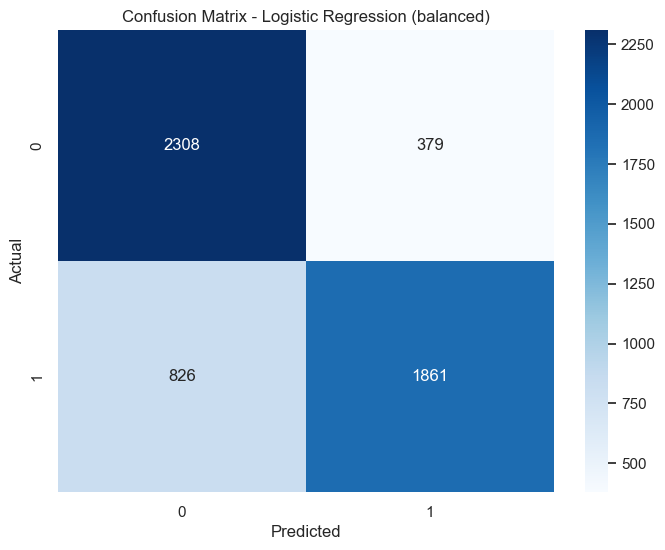

In [324]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test_validation_balanced, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (balanced)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [325]:
X_test_validation, Y_test_validation = X_test.loc[2018].to_numpy(dtype='int'), y_test.loc[2018].to_numpy(dtype='int')
Y_pred = best_model.predict(X_test_validation)
acc = accuracy_score(Y_test_validation, Y_pred)
prec = precision_score(Y_test_validation, Y_pred)
rec = recall_score(Y_test_validation, Y_pred)
f1 = f1_score(Y_test_validation, Y_pred)
roc=roc_auc_score(Y_test_validation, Y_pred)

results_logit_gs = pd.DataFrame([['Logistic Regression with PCA and Grid Search', acc, prec,rec, f1, roc]],
                               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC'])

results_logit_gs

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression with PCA and Grid Search,0.854572,0.047739,0.527778,0.087558,0.693364


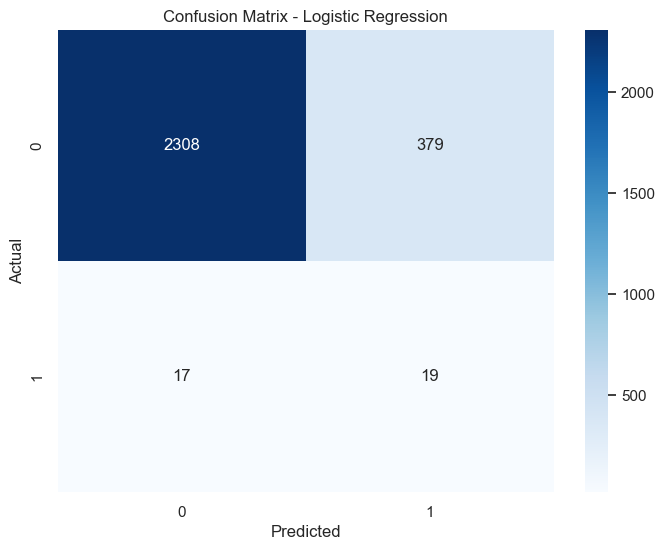

In [326]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test_validation, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Model 2: Stochastic Gradient Descent (SGD Classifier) with PCA and Grid Search

In [33]:
X = bankruptcy_merged_df_train[features]
y = bankruptcy_merged_df_train['status_label']

# Define pipeline
def create_pipeline(n_components):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('classifier', SGDClassifier(class_weight='balanced', loss='log_loss', penalty='elasticnet', alpha=n_components[0], l1_ratio=n_components[1], learning_rate='optimal', random_state=1))
    ])

# Define range of components to test
n_test = 10
N_c_logit = np.sort(uniform(loc=0, scale=0.0001).rvs(n_test))
n_l1_ratio_logit = np.sort(uniform(loc=0, scale=1).rvs(n_test))
configs = project_helper.model_configs([(C_logit, l1_ratio_logit/10) for C_logit in N_c_logit for l1_ratio_logit in n_l1_ratio_logit ]) # define the range to grid search on

# Initialize walk-forward validation
wf_validator_sgd = project_helper.walk_forward_rolling_train(create_pipeline, X, y)

# Perform grid search
wf_validator_sgd.grid_search(configs)

Total configs: 100


  1%|          | 1/100 [00:06<10:29,  6.36s/it]

 > 0.685
(1.0271332063193416e-06, 0.005803007276510575) 0.6845960808683473 0.25880381610305164


  2%|▏         | 2/100 [00:13<11:16,  6.91s/it]

 > 0.761
(1.0271332063193416e-06, 0.009408685746784818) 0.760594436932582 0.2366635225330879


  3%|▎         | 3/100 [00:20<11:12,  6.93s/it]

 > 0.766
(1.0271332063193416e-06, 0.027955757397094383) 0.7663756039618279 0.24678380867753733


  4%|▍         | 4/100 [00:27<11:17,  7.05s/it]

 > 0.766
(1.0271332063193416e-06, 0.04033230240359885) 0.7661090857064156 0.1865796807223804


  5%|▌         | 5/100 [00:34<11:06,  7.01s/it]

 > 0.696
(1.0271332063193416e-06, 0.04620277025068098) 0.6961170492372805 0.21982050832334157


  6%|▌         | 6/100 [00:41<10:59,  7.01s/it]

 > 0.611
(1.0271332063193416e-06, 0.0531168846488418) 0.6113053136029903 0.2822140992637918


  7%|▋         | 7/100 [00:48<10:51,  7.01s/it]

 > 0.717
(1.0271332063193416e-06, 0.06165233601143442) 0.7172167629128029 0.21801211750076657


  8%|▊         | 8/100 [00:55<10:39,  6.95s/it]

 > 0.703
(1.0271332063193416e-06, 0.06504952209632456) 0.7028842781766007 0.2202233313867314


  9%|▉         | 9/100 [01:02<10:29,  6.91s/it]

 > 0.625
(1.0271332063193416e-06, 0.06546385105909512) 0.6247113506782905 0.2700702007925393


 10%|█         | 10/100 [01:09<10:21,  6.91s/it]

 > 0.667
(1.0271332063193416e-06, 0.09528472078498318) 0.6674688054858261 0.2973453599347841


 11%|█         | 11/100 [01:16<10:17,  6.93s/it]

 > 0.836
(2.0609552561849743e-05, 0.005803007276510575) 0.8364343411514642 0.1450623407212993


 12%|█▏        | 12/100 [01:23<10:10,  6.93s/it]

 > 0.828
(2.0609552561849743e-05, 0.009408685746784818) 0.8276157314110336 0.14916133115525543


 13%|█▎        | 13/100 [01:29<09:52,  6.82s/it]

 > 0.846
(2.0609552561849743e-05, 0.027955757397094383) 0.8462865905843521 0.14119549377372642


 14%|█▍        | 14/100 [01:36<09:37,  6.71s/it]

 > 0.846
(2.0609552561849743e-05, 0.04033230240359885) 0.8455033228969556 0.1465976680183145


 15%|█▌        | 15/100 [01:42<09:30,  6.71s/it]

 > 0.827
(2.0609552561849743e-05, 0.04620277025068098) 0.827416079170826 0.15301872531256797


 16%|█▌        | 16/100 [01:49<09:22,  6.69s/it]

 > 0.831
(2.0609552561849743e-05, 0.0531168846488418) 0.8307519478360516 0.14532391756443963


 17%|█▋        | 17/100 [01:56<09:16,  6.70s/it]

 > 0.793
(2.0609552561849743e-05, 0.06165233601143442) 0.7925231556140214 0.14933013109120274


 18%|█▊        | 18/100 [02:02<09:06,  6.67s/it]

 > 0.782
(2.0609552561849743e-05, 0.06504952209632456) 0.7817429606531879 0.203648634793651


 19%|█▉        | 19/100 [02:09<09:00,  6.67s/it]

 > 0.782
(2.0609552561849743e-05, 0.06546385105909512) 0.7816669641333766 0.20368147257029398


 20%|██        | 20/100 [02:16<09:03,  6.79s/it]

 > 0.809
(2.0609552561849743e-05, 0.09528472078498318) 0.8094234396796415 0.14248904386409347


 21%|██        | 21/100 [02:23<08:54,  6.77s/it]

 > 0.853
(4.463735919946833e-05, 0.005803007276510575) 0.8530833934288463 0.12616184187178403


 22%|██▏       | 22/100 [02:30<08:55,  6.86s/it]

 > 0.848
(4.463735919946833e-05, 0.009408685746784818) 0.8484129449307252 0.13043680020515727


 23%|██▎       | 23/100 [02:37<08:47,  6.85s/it]

 > 0.845
(4.463735919946833e-05, 0.027955757397094383) 0.8450795380200742 0.14451994756899544


 24%|██▍       | 24/100 [02:44<08:39,  6.83s/it]

 > 0.840
(4.463735919946833e-05, 0.04033230240359885) 0.8404991924716875 0.14660586545175683


 25%|██▌       | 25/100 [02:50<08:32,  6.83s/it]

 > 0.851
(4.463735919946833e-05, 0.04620277025068098) 0.8507453896650776 0.14851211526315347


 26%|██▌       | 26/100 [02:57<08:23,  6.80s/it]

 > 0.855
(4.463735919946833e-05, 0.0531168846488418) 0.855014697132708 0.1486879070592575


 27%|██▋       | 27/100 [03:05<08:27,  6.96s/it]

 > 0.853
(4.463735919946833e-05, 0.06165233601143442) 0.8526378661448761 0.14439835307686777


 28%|██▊       | 28/100 [03:11<08:18,  6.92s/it]

 > 0.859
(4.463735919946833e-05, 0.06504952209632456) 0.8593967532222119 0.14729247044425392


 29%|██▉       | 29/100 [03:18<08:12,  6.94s/it]

 > 0.858
(4.463735919946833e-05, 0.06546385105909512) 0.8583113993558947 0.14664710460452327


 30%|███       | 30/100 [03:25<08:03,  6.90s/it]

 > 0.875
(4.463735919946833e-05, 0.09528472078498318) 0.8750338615214662 0.12809055223040985


 31%|███       | 31/100 [03:32<07:51,  6.83s/it]

 > 0.847
(4.787736335357022e-05, 0.005803007276510575) 0.8472549926558471 0.13108204445505783


 32%|███▏      | 32/100 [03:39<07:54,  6.98s/it]

 > 0.853
(4.787736335357022e-05, 0.009408685746784818) 0.8527782922292468 0.1347801188176136


 33%|███▎      | 33/100 [03:46<07:40,  6.88s/it]

 > 0.839
(4.787736335357022e-05, 0.027955757397094383) 0.8392419078834225 0.1445088115242212


 34%|███▍      | 34/100 [03:52<07:28,  6.79s/it]

 > 0.845
(4.787736335357022e-05, 0.04033230240359885) 0.8451252997883014 0.14819315575321185


 35%|███▌      | 35/100 [03:59<07:19,  6.77s/it]

 > 0.847
(4.787736335357022e-05, 0.04620277025068098) 0.8468407235097344 0.14696593875114625


 36%|███▌      | 36/100 [04:06<07:16,  6.83s/it]

 > 0.858
(4.787736335357022e-05, 0.0531168846488418) 0.8576726964375806 0.13395848233538424


 37%|███▋      | 37/100 [04:13<07:08,  6.80s/it]

 > 0.862
(4.787736335357022e-05, 0.06165233601143442) 0.861909783031607 0.1437139424424231


 38%|███▊      | 38/100 [04:20<07:04,  6.84s/it]

 > 0.864
(4.787736335357022e-05, 0.06504952209632456) 0.8640709819440447 0.14148549313369163


 39%|███▉      | 39/100 [04:27<07:00,  6.89s/it]

 > 0.868
(4.787736335357022e-05, 0.06546385105909512) 0.8678641189199203 0.13265904134919682


 40%|████      | 40/100 [04:33<06:49,  6.83s/it]

 > 0.863
(4.787736335357022e-05, 0.09528472078498318) 0.8628033669912438 0.14614491049749267


 41%|████      | 41/100 [04:40<06:38,  6.75s/it]

 > 0.874
(5.632016186805716e-05, 0.005803007276510575) 0.8740646546296793 0.13263650606118285


 42%|████▏     | 42/100 [04:47<06:28,  6.69s/it]

 > 0.871
(5.632016186805716e-05, 0.009408685746784818) 0.8711243550070856 0.13281262583714917


 43%|████▎     | 43/100 [04:53<06:22,  6.72s/it]

 > 0.857
(5.632016186805716e-05, 0.027955757397094383) 0.8572786169873351 0.14515991451400784


 44%|████▍     | 44/100 [05:00<06:19,  6.78s/it]

 > 0.856
(5.632016186805716e-05, 0.04033230240359885) 0.8561415872846816 0.13382570837218047


 45%|████▌     | 45/100 [05:07<06:15,  6.82s/it]

 > 0.855
(5.632016186805716e-05, 0.04620277025068098) 0.8547721410003435 0.13585951437895513


 46%|████▌     | 46/100 [05:14<06:03,  6.73s/it]

 > 0.860
(5.632016186805716e-05, 0.0531168846488418) 0.8596018115722162 0.13550046201006047


 47%|████▋     | 47/100 [05:21<06:01,  6.83s/it]

 > 0.863
(5.632016186805716e-05, 0.06165233601143442) 0.8630219572202934 0.13521786966212618


 48%|████▊     | 48/100 [05:27<05:51,  6.76s/it]

 > 0.862
(5.632016186805716e-05, 0.06504952209632456) 0.862016566930944 0.13484628642585675


 49%|████▉     | 49/100 [05:34<05:40,  6.69s/it]

 > 0.862
(5.632016186805716e-05, 0.06546385105909512) 0.8619376811971222 0.13484740068812498


 50%|█████     | 50/100 [05:41<05:35,  6.71s/it]

 > 0.854
(5.632016186805716e-05, 0.09528472078498318) 0.8537141550492221 0.13395820395279798


 51%|█████     | 51/100 [05:47<05:28,  6.70s/it]

 > 0.867
(6.166268045350884e-05, 0.005803007276510575) 0.8673261254926902 0.12872107678276637


 52%|█████▏    | 52/100 [05:54<05:20,  6.68s/it]

 > 0.865
(6.166268045350884e-05, 0.009408685746784818) 0.8650546638182169 0.1291115474450611


 53%|█████▎    | 53/100 [06:01<05:18,  6.78s/it]

 > 0.848
(6.166268045350884e-05, 0.027955757397094383) 0.8475134387240405 0.1369444977896319


 54%|█████▍    | 54/100 [06:08<05:12,  6.80s/it]

 > 0.854
(6.166268045350884e-05, 0.04033230240359885) 0.8536823964397788 0.1373646324754023


 55%|█████▌    | 55/100 [06:15<05:09,  6.87s/it]

 > 0.846
(6.166268045350884e-05, 0.04620277025068098) 0.8458579222332391 0.13575724546432902


 56%|█████▌    | 56/100 [06:22<05:07,  6.99s/it]

 > 0.859
(6.166268045350884e-05, 0.0531168846488418) 0.8585278404495768 0.13163684201130646


 57%|█████▋    | 57/100 [06:28<04:49,  6.73s/it]

 > 0.857
(6.166268045350884e-05, 0.06165233601143442) 0.8566464794055612 0.13088274083060508


 58%|█████▊    | 58/100 [06:35<04:46,  6.83s/it]

 > 0.850
(6.166268045350884e-05, 0.06504952209632456) 0.8504924170423164 0.12935391723471718


 59%|█████▉    | 59/100 [06:42<04:44,  6.94s/it]

 > 0.850
(6.166268045350884e-05, 0.06546385105909512) 0.8504719386674803 0.1293397092389923


 60%|██████    | 60/100 [06:50<04:40,  7.02s/it]

 > 0.862
(6.166268045350884e-05, 0.09528472078498318) 0.8622620313880762 0.12478536325507072


 61%|██████    | 61/100 [06:56<04:30,  6.95s/it]

 > 0.870
(8.39086838189776e-05, 0.005803007276510575) 0.869587166448355 0.12211145531168736


 62%|██████▏   | 62/100 [07:03<04:21,  6.87s/it]

 > 0.870
(8.39086838189776e-05, 0.009408685746784818) 0.8697733539389763 0.12234020053023524


 63%|██████▎   | 63/100 [07:10<04:16,  6.94s/it]

 > 0.863
(8.39086838189776e-05, 0.027955757397094383) 0.8632776976243501 0.11792848150734107


 64%|██████▍   | 64/100 [07:17<04:02,  6.75s/it]

 > 0.860
(8.39086838189776e-05, 0.04033230240359885) 0.8596576415193127 0.12197173360189216


 65%|██████▌   | 65/100 [07:23<03:57,  6.78s/it]

 > 0.857
(8.39086838189776e-05, 0.04620277025068098) 0.8569392725779255 0.11994648100818907


 66%|██████▌   | 66/100 [07:30<03:53,  6.87s/it]

 > 0.865
(8.39086838189776e-05, 0.0531168846488418) 0.8654564879569744 0.12435247606142073


 67%|██████▋   | 67/100 [07:37<03:45,  6.83s/it]

 > 0.851
(8.39086838189776e-05, 0.06165233601143442) 0.8512187189585184 0.12441069633833925


 68%|██████▊   | 68/100 [07:44<03:40,  6.89s/it]

 > 0.851
(8.39086838189776e-05, 0.06504952209632456) 0.850519040345349 0.12402677661124172


 69%|██████▉   | 69/100 [07:51<03:31,  6.81s/it]

 > 0.851
(8.39086838189776e-05, 0.06546385105909512) 0.8505018906283193 0.12402839924347878


 70%|███████   | 70/100 [07:58<03:25,  6.86s/it]

 > 0.867
(8.39086838189776e-05, 0.09528472078498318) 0.8673779733517278 0.08862458203329754


 71%|███████   | 71/100 [08:05<03:20,  6.93s/it]

 > 0.870
(8.846633572337793e-05, 0.005803007276510575) 0.8701197780995277 0.12133438424550584


 72%|███████▏  | 72/100 [08:12<03:14,  6.94s/it]

 > 0.873
(8.846633572337793e-05, 0.009408685746784818) 0.8731850929452694 0.11799975214210617


 73%|███████▎  | 73/100 [08:19<03:08,  6.99s/it]

 > 0.856
(8.846633572337793e-05, 0.027955757397094383) 0.8564227667924531 0.11627771445033208


 74%|███████▍  | 74/100 [08:26<02:59,  6.92s/it]

 > 0.854
(8.846633572337793e-05, 0.04033230240359885) 0.8542627969569051 0.11724408186150397


 75%|███████▌  | 75/100 [08:32<02:50,  6.82s/it]

 > 0.879
(8.846633572337793e-05, 0.04620277025068098) 0.8789024060845135 0.0931230511243479


 76%|███████▌  | 76/100 [08:39<02:45,  6.88s/it]

 > 0.867
(8.846633572337793e-05, 0.0531168846488418) 0.8668409277347922 0.12450706976346283


 77%|███████▋  | 77/100 [08:46<02:35,  6.77s/it]

 > 0.865
(8.846633572337793e-05, 0.06165233601143442) 0.8649095978106945 0.12403354594004005


 78%|███████▊  | 78/100 [08:53<02:30,  6.83s/it]

 > 0.866
(8.846633572337793e-05, 0.06504952209632456) 0.8657171975921976 0.12346413688926722


 79%|███████▉  | 79/100 [08:59<02:22,  6.77s/it]

 > 0.867
(8.846633572337793e-05, 0.06546385105909512) 0.8674687750706694 0.12460684778868367


 80%|████████  | 80/100 [09:06<02:16,  6.80s/it]

 > 0.875
(8.846633572337793e-05, 0.09528472078498318) 0.8747727979020541 0.09191486010000317


 81%|████████  | 81/100 [09:13<02:09,  6.83s/it]

 > 0.887
(9.13521756924212e-05, 0.005803007276510575) 0.8871625162198133 0.0829472908006472


 82%|████████▏ | 82/100 [09:20<02:02,  6.80s/it]

 > 0.873
(9.13521756924212e-05, 0.009408685746784818) 0.8726961730968014 0.11720086191439211


 83%|████████▎ | 83/100 [09:26<01:53,  6.70s/it]

 > 0.854
(9.13521756924212e-05, 0.027955757397094383) 0.8541849075732547 0.11576946557785188


 84%|████████▍ | 84/100 [09:33<01:46,  6.68s/it]

 > 0.855
(9.13521756924212e-05, 0.04033230240359885) 0.8549210644789739 0.11681151082495471


 85%|████████▌ | 85/100 [09:40<01:40,  6.70s/it]

 > 0.864
(9.13521756924212e-05, 0.04620277025068098) 0.8640544478620852 0.12193956605963902


 86%|████████▌ | 86/100 [09:47<01:34,  6.78s/it]

 > 0.878
(9.13521756924212e-05, 0.0531168846488418) 0.8777894230780159 0.09268293677540536


 87%|████████▋ | 87/100 [09:54<01:28,  6.79s/it]

 > 0.868
(9.13521756924212e-05, 0.06165233601143442) 0.8680347337216456 0.1244974096849929


 88%|████████▊ | 88/100 [10:01<01:22,  6.90s/it]

 > 0.868
(9.13521756924212e-05, 0.06504952209632456) 0.8680478925064782 0.12448215796301586


 89%|████████▉ | 89/100 [10:07<01:15,  6.82s/it]

 > 0.868
(9.13521756924212e-05, 0.06546385105909512) 0.867961209393111 0.12455678338747249


 90%|█████████ | 90/100 [10:14<01:08,  6.88s/it]

 > 0.874
(9.13521756924212e-05, 0.09528472078498318) 0.8736846916706088 0.0898641679139612


 91%|█████████ | 91/100 [10:21<01:00,  6.73s/it]

 > 0.873
(9.862751507736228e-05, 0.005803007276510575) 0.8731526890895115 0.11648462320018955


 92%|█████████▏| 92/100 [10:28<00:54,  6.79s/it]

 > 0.879
(9.862751507736228e-05, 0.009408685746784818) 0.87865574312426 0.11526304154846881


 93%|█████████▎| 93/100 [10:35<00:47,  6.84s/it]

 > 0.861
(9.862751507736228e-05, 0.027955757397094383) 0.861343199161796 0.11030545881561164


 94%|█████████▍| 94/100 [10:41<00:40,  6.78s/it]

 > 0.870
(9.862751507736228e-05, 0.04033230240359885) 0.8702242115159075 0.1185753162777462


 95%|█████████▌| 95/100 [10:48<00:33,  6.66s/it]

 > 0.872
(9.862751507736228e-05, 0.04620277025068098) 0.8722154253050596 0.12012058559778643


 96%|█████████▌| 96/100 [10:55<00:27,  6.78s/it]

 > 0.867
(9.862751507736228e-05, 0.0531168846488418) 0.8668891348400241 0.1221148018442749


 97%|█████████▋| 97/100 [11:02<00:20,  6.89s/it]

 > 0.861
(9.862751507736228e-05, 0.06165233601143442) 0.8609294909991508 0.10811912558153884


 98%|█████████▊| 98/100 [11:09<00:13,  6.94s/it]

 > 0.849
(9.862751507736228e-05, 0.06504952209632456) 0.8485028109801673 0.12799475125864984


 99%|█████████▉| 99/100 [11:16<00:06,  6.94s/it]

 > 0.849
(9.862751507736228e-05, 0.06546385105909512) 0.8485439683246954 0.1280055689171077


100%|██████████| 100/100 [11:23<00:00,  6.83s/it]

 > 0.876
(9.862751507736228e-05, 0.09528472078498318) 0.8759567006955296 0.09115706897695086
done


In [34]:
wf_validator_sgd.plot_validation()

Best model: alpha = 8.8598e-05, l1_ratio=0.00781082, estimated test set recall: 0.8850281

In [327]:
X_test = bankruptcy_merged_df_test[features]
y_test = bankruptcy_merged_df_test['status_label']
sm = SMOTE()
X_test_balanced, Y_test_balanced = sm.fit_resample(X=X_test.loc[2016:2018].to_numpy(dtype='int'),y=y_test.loc[2016:2018].to_numpy(dtype='int'))
steps_sgdc = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
              ('pca', PCA(n_components=0.95)),
              ('sgdc', SGDClassifier(penalty='elasticnet',alpha=8.8598e-05,max_iter=10000,l1_ratio=0.00781082))
             ]

pl_sgdc = Pipeline(steps_sgdc)
best_model = pl_sgdc.fit(X_test_balanced,Y_test_balanced)

In [328]:
X_test_validation_balanced, Y_test_validation_balanced = sm.fit_resample(X=X_test.loc[2018].to_numpy(dtype='int'),y=y_test.loc[2018].to_numpy(dtype='int'))
Y_pred = best_model.predict(X_test_validation_balanced)
acc = accuracy_score(Y_test_validation_balanced, Y_pred)
prec = precision_score(Y_test_validation_balanced, Y_pred)
rec = recall_score(Y_test_validation_balanced, Y_pred)
f1 = f1_score(Y_test_validation_balanced, Y_pred)
roc=roc_auc_score(Y_test_validation_balanced, Y_pred)


results_sgdc_rs_balanced = pd.DataFrame([['SGD Classifier with PCA and Grid Search', acc,prec,rec, f1, roc]],
                               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC'])

pd.concat([results_logit_gs_balanced, results_sgdc_rs_balanced], axis=0, ignore_index=True)

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression with PCA and Grid Search,0.775772,0.830804,0.692594,0.755429,0.775772
1,SGD Classifier with PCA and Grid Search,0.864347,0.868322,0.858951,0.863611,0.864347


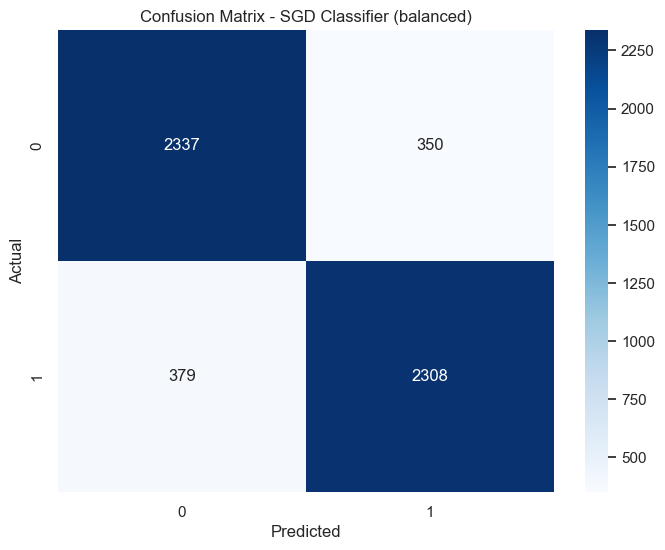

In [329]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test_validation_balanced, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SGD Classifier (balanced)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [331]:
X_test_validation, Y_test_validation = X_test.loc[2018].to_numpy(dtype='int'), y_test.loc[2018].to_numpy(dtype='int')
Y_pred = best_model.predict(X_test_validation)
acc = accuracy_score(Y_test_validation, Y_pred)
prec = precision_score(Y_test_validation, Y_pred)
rec = recall_score(Y_test_validation, Y_pred)
f1 = f1_score(Y_test_validation, Y_pred)
roc=roc_auc_score(Y_test_validation, Y_pred)

results_sgdc_rs = pd.DataFrame([['SGD Classifier with PCA and Grid Search', acc,prec,rec, f1, roc]],
                               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC'])

pd.concat([results_logit_gs, results_sgdc_rs], axis=0, ignore_index=True)

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression with PCA and Grid Search,0.854572,0.047739,0.527778,0.087558,0.693364
1,SGD Classifier with PCA and Grid Search,0.868527,0.074074,0.777778,0.135266,0.823760


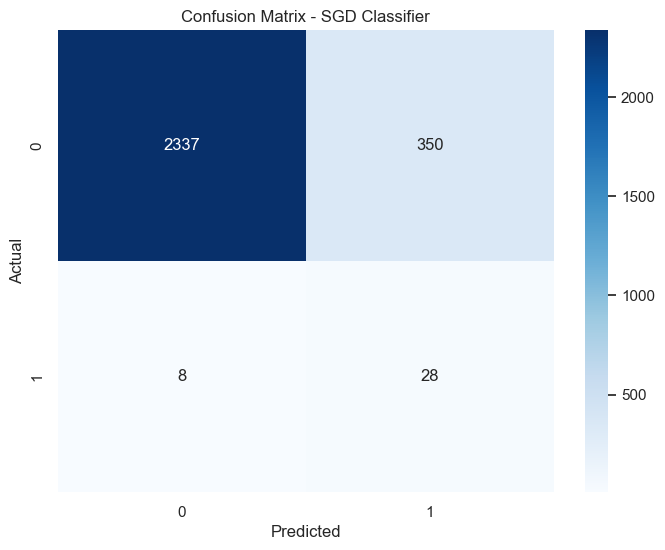

In [332]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test_validation, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SGD Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Model 3: Extreme Gradient Boosting (XGBoost Classifier) with PCA and Grid Search

In [41]:
X = bankruptcy_merged_df_train[features]
y = bankruptcy_merged_df_train['status_label']

# Define pipeline
def create_pipeline(n_components):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('classifier', xgb.XGBClassifier(n_jobs=-1, eval_metric='logloss',use_label_encoder=False, random_state=1, max_depth=n_components[0], learning_rate=n_components[1], n_estimators=n_components[2],subsample=n_components[3],colsample_bytree=n_components[4]))
    ])

# Define range of components to test
configs = project_helper.model_configs([(max_depth, learning_rate/100, n_estimators, subsample, colsample_bytree)for learning_rate in [1, 50, 100] for max_depth in [3, 7] for n_estimators in [100, 300] for subsample in [0.5, 1] for colsample_bytree in [0.5, 1]]) # define the range to grid search on

# Initialize walk-forward validation
wf_validator_xgb = project_helper.walk_forward_rolling_train(create_pipeline, X, y)

# Perform grid search
wf_validator_xgb.grid_search(configs)

Total configs: 48




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python

 > 0.680
(3, 0.01, 100, 0.5, 0.5) 0.6800199795259724 0.2798227774577572


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.696
(3, 0.01, 100, 0.5, 1) 0.6959609823336705 0.27504530076968386


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.673
(3, 0.01, 100, 1, 0.5) 0.673213235206038 0.2797861658061925


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.699
(3, 0.01, 100, 1, 1) 0.6991919879929303 0.26987168002736334


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.591
(3, 0.01, 300, 0.5, 0.5) 0.5914028516090255 0.3328918491325732


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.647
(3, 0.01, 300, 0.5, 1) 0.6472467904339805 0.27801596278553903


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.591
(3, 0.01, 300, 1, 0.5) 0.5914941910465968 0.3329259881550346


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.643
(3, 0.01, 300, 1, 1) 0.6431700656401284 0.2798891772179995


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.513
(7, 0.01, 100, 0.5, 0.5) 0.5128408701620165 0.3292780401833415


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:55:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.568
(7, 0.01, 100, 0.5, 1) 0.5676746560081415 0.2982106809499707


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.513
(7, 0.01, 100, 1, 0.5) 0.5126928100475946 0.3304499760162897


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.585
(7, 0.01, 100, 1, 1) 0.585152855898647 0.2838415474975433


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.491
(7, 0.01, 300, 0.5, 0.5) 0.49073619409627695 0.32832750583169973


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.507
(7, 0.01, 300, 0.5, 1) 0.5073016127584407 0.3176564174967378


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.488
(7, 0.01, 300, 1, 0.5) 0.4878141218400546 0.32722091341381254


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.512
(7, 0.01, 300, 1, 1) 0.5124176622361116 0.3036720006645008


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.407
(3, 0.5, 100, 0.5, 0.5) 0.40662587347002105 0.2847359883935018


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.425
(3, 0.5, 100, 0.5, 1) 0.42541779971882226 0.2672918589459584


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.430
(3, 0.5, 100, 1, 0.5) 0.4301063623434579 0.29392857738577316


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.412
(3, 0.5, 100, 1, 1) 0.4118797269887729 0.293915438225508


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.346
(3, 0.5, 300, 0.5, 0.5) 0.3462528432390764 0.2821885205508258


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.334
(3, 0.5, 300, 0.5, 1) 0.3344731849304621 0.2763204249392184


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.356
(3, 0.5, 300, 1, 0.5) 0.356203325275145 0.28715288920103044


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.344
(3, 0.5, 300, 1, 1) 0.34381017584905343 0.2913099157540379


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.317
(7, 0.5, 100, 0.5, 0.5) 0.31650796801170555 0.29653062151671694


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.309
(7, 0.5, 100, 0.5, 1) 0.3094772780136362 0.296531390665479


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.308
(7, 0.5, 100, 1, 0.5) 0.3084823452302676 0.30044215037694216


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.302
(7, 0.5, 100, 1, 1) 0.30209127068934205 0.2991269319365729


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[11:59:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.307
(7, 0.5, 300, 0.5, 0.5) 0.3069939528263769 0.29933623522976704


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:00:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:00:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:00:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:00:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.307
(7, 0.5, 300, 0.5, 1) 0.3069988769661678 0.2985764425731462


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:00:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:00:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:00:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.302
(7, 0.5, 300, 1, 0.5) 0.3021415983978728 0.30333232835669854


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:00:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:00:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:00:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.298
(7, 0.5, 300, 1, 1) 0.2977434240100965 0.3031003085796121


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.381
(3, 1.0, 100, 0.5, 0.5) 0.38138731755632493 0.2736365493150659


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.358
(3, 1.0, 100, 0.5, 1) 0.3579591424128768 0.28018892476644713


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.364
(3, 1.0, 100, 1, 0.5) 0.3635991599953314 0.2674429638178132


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.357
(3, 1.0, 100, 1, 1) 0.35682768900214334 0.2810724161851819


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.328
(3, 1.0, 300, 0.5, 0.5) 0.32844402371411163 0.26906074807583524


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:01:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.314
(3, 1.0, 300, 0.5, 1) 0.3143655158242949 0.27189052000192027


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.318
(3, 1.0, 300, 1, 0.5) 0.31844002049783965 0.2784682286280035


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.317
(3, 1.0, 300, 1, 1) 0.3171104675562489 0.2886440394181174


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.302
(7, 1.0, 100, 0.5, 0.5) 0.30170583582985877 0.29354716191220864


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.293
(7, 1.0, 100, 0.5, 1) 0.2933400940207814 0.2669234104428081


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.303
(7, 1.0, 100, 1, 0.5) 0.30256990921605803 0.30087968234686346


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:02:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.298
(7, 1.0, 100, 1, 1) 0.2978798111461875 0.28572732758792274


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.301
(7, 1.0, 300, 0.5, 0.5) 0.3011292102230682 0.29596890108307994


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.295
(7, 1.0, 300, 0.5, 1) 0.29548305680030573 0.277041412260324


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.303
(7, 1.0, 300, 1, 0.5) 0.30323309306023954 0.30486358752933124


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:03:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:04:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:04:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[12:04:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Library/Frameworks/Python.f

 > 0.295
(7, 1.0, 300, 1, 1) 0.2949635236391911 0.28738793054279593
done


In [42]:
wf_validator_xgb.scores

[{'ModelParam': '(3, 0.01, 100, 1, 1)',
  'Results': (0.6991919879929303, 0.26987168002736334)},
 {'ModelParam': '(3, 0.01, 100, 0.5, 1)',
  'Results': (0.6959609823336705, 0.27504530076968386)},
 {'ModelParam': '(3, 0.01, 100, 0.5, 0.5)',
  'Results': (0.6800199795259724, 0.2798227774577572)},
 {'ModelParam': '(3, 0.01, 100, 1, 0.5)',
  'Results': (0.673213235206038, 0.2797861658061925)},
 {'ModelParam': '(3, 0.01, 300, 0.5, 1)',
  'Results': (0.6472467904339805, 0.27801596278553903)},
 {'ModelParam': '(3, 0.01, 300, 1, 1)',
  'Results': (0.6431700656401284, 0.2798891772179995)},
 {'ModelParam': '(3, 0.01, 300, 1, 0.5)',
  'Results': (0.5914941910465968, 0.3329259881550346)},
 {'ModelParam': '(3, 0.01, 300, 0.5, 0.5)',
  'Results': (0.5914028516090255, 0.3328918491325732)},
 {'ModelParam': '(7, 0.01, 100, 1, 1)',
  'Results': (0.585152855898647, 0.2838415474975433)},
 {'ModelParam': '(7, 0.01, 100, 0.5, 1)',
  'Results': (0.5676746560081415, 0.2982106809499707)},
 {'ModelParam': '(7, 

Best model: max_depth = 3, learning_rate = 0.01, n_estimator = 100, subsample = 1, colsample_bytree = 1, estimated test set recall: 0.69919

In [333]:
X_test = bankruptcy_merged_df_test[features]
y_test = bankruptcy_merged_df_test['status_label']
sm = SMOTE()
X_test_balanced, Y_test_balanced = sm.fit_resample(X=X_test.loc[2016:2018].to_numpy(dtype='int'),y=y_test.loc[2016:2018].to_numpy(dtype='int'))
# Pipeline
steps_xgb = [
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('xgb', xgb.XGBClassifier(max_depth=3, learning_rate=0.01, n_estimators=100,subsample=1,colsample_bytree=1))
]

pl_xgb = Pipeline(steps_xgb)
best_model = pl_xgb.fit(X_test_balanced,Y_test_balanced)

In [334]:
X_test_validation_balanced, Y_test_validation_balanced = sm.fit_resample(X=X_test.loc[2018].to_numpy(dtype='int'),y=y_test.loc[2018].to_numpy(dtype='int'))
Y_pred = best_model.predict(X_test_validation_balanced)
acc = accuracy_score(Y_test_validation_balanced, Y_pred)
prec = precision_score(Y_test_validation_balanced, Y_pred)
rec = recall_score(Y_test_validation_balanced, Y_pred)
f1 = f1_score(Y_test_validation_balanced, Y_pred)
roc=roc_auc_score(Y_test_validation_balanced, Y_pred)

results_xgb_rs_balanced = pd.DataFrame([['XGBoost Classifier with PCA and Grid Search', acc,prec,rec, f1, roc]],
                               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC'])

pd.concat([results_logit_gs_balanced, results_sgdc_rs_balanced, results_xgb_rs_balanced], axis=0, ignore_index=True)

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression with PCA and Grid Search,0.775772,0.830804,0.692594,0.755429,0.775772
1,SGD Classifier with PCA and Grid Search,0.864347,0.868322,0.858951,0.863611,0.864347
2,XGBoost Classifier with PCA and Grid Search,0.851507,0.831986,0.880908,0.855748,0.851507


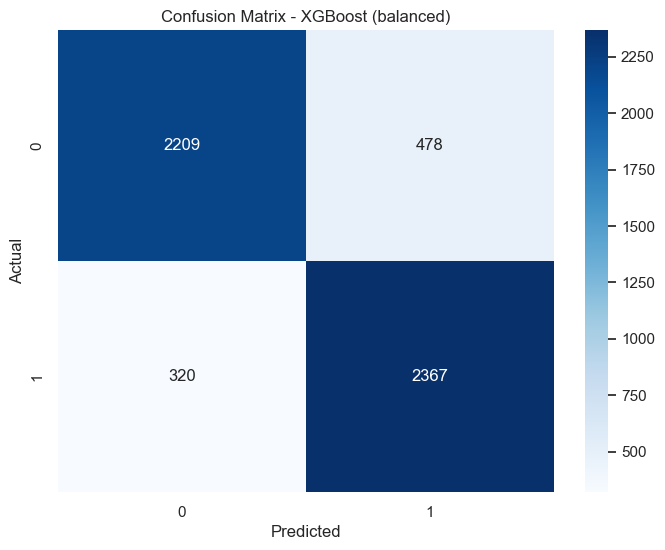

In [335]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test_validation_balanced, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost (balanced)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [337]:
X_test_validation, Y_test_validation = X_test.loc[2018].to_numpy(dtype='int'), y_test.loc[2018].to_numpy(dtype='int')
Y_pred = best_model.predict(X_test_validation)
acc = accuracy_score(Y_test_validation, Y_pred)
prec = precision_score(Y_test_validation, Y_pred)
rec = recall_score(Y_test_validation, Y_pred)
f1 = f1_score(Y_test_validation, Y_pred)
roc=roc_auc_score(Y_test_validation, Y_pred)

results_xgb_rs = pd.DataFrame([['XGBoost Classifier with PCA and Grid Search', acc,prec,rec, f1, roc]],
                               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC'])

pd.concat([results_logit_gs, results_sgdc_rs,results_xgb_rs], axis=0, ignore_index=True)

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression with PCA and Grid Search,0.854572,0.047739,0.527778,0.087558,0.693364
1,SGD Classifier with PCA and Grid Search,0.868527,0.074074,0.777778,0.135266,0.823760
2,XGBoost Classifier with PCA and Grid Search,0.821520,0.055336,0.777778,0.103321,0.799942


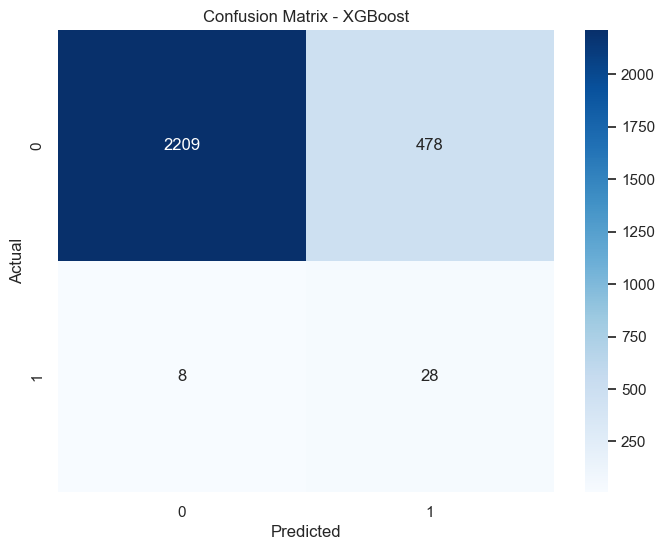

In [338]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test_validation, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Model 4: Isolation Forest with PCA and Grid Search

In [63]:
X = bankruptcy_merged_df_train[features]
y = bankruptcy_merged_df_train['status_label']

importlib.reload(project_helper)

# Define pipeline
def create_pipeline(n_components):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('classifier', IsolationForest( contamination=n_components[0],random_state=42,bootstrap=n_components[1]))
    ])

# Define range of components to test
outlier_factor = sum(y)/len(y)
configs = project_helper.model_configs([(contamination, bootstrap)for contamination in [outlier_factor,'auto']  for bootstrap in [True, False]  ]) # define the range to grid search on

# Initialize walk-forward validation
wf_validator_of = project_helper.walk_forward_rolling_train(create_pipeline, X, y, flip= True)

# Perform grid search
wf_validator_of.grid_search(configs)

Total configs: 4


  0%|          | 0/4 [00:00<?, ?it/s]



 > 0.005
(0.0075674490019741174, True) 0.005048160657455033 0.01356880425584136


 > 0.006
(0.0075674490019741174, False) 0.00589424165087079 0.014210960754751678


 > 0.033
('auto', True) 0.03273846611526933 0.05544465715667606




100%|██████████| 4/4 [00:35<00:00,  8.87s/it]

 > 0.037
('auto', False) 0.03698553663981937 0.06229109880698931
done


In [64]:
wf_validator_of.scores

[{'ModelParam': "('auto', False)",
  'Results': (0.03698553663981937, 0.06229109880698931)},
 {'ModelParam': "('auto', True)",
  'Results': (0.03273846611526933, 0.05544465715667606)},
 {'ModelParam': '(0.0075674490019741174, False)',
  'Results': (0.00589424165087079, 0.014210960754751678)},
 {'ModelParam': '(0.0075674490019741174, True)',
  'Results': (0.005048160657455033, 0.01356880425584136)}]

Best model: contamination = auto, bootstrapping = False, estimated test set recall: 0.0369855

In [339]:
steps_iforest = [
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('iforest', IsolationForest(contamination='auto',bootstrap=False, random_state=42))
]

best_model = Pipeline(steps_iforest)

X_test = bankruptcy_merged_df_test[features]
y_test = bankruptcy_merged_df_test['status_label']
sm = SMOTE()
X_test_balanced, Y_test_balanced = sm.fit_resample(X=X_test.loc[2016:2018].to_numpy(dtype='int'),y=y_test.loc[2016:2018].to_numpy(dtype='int'))
# Fit the model
best_model.fit(X_test_balanced)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('iforest', IsolationForest(random_state=42))])

In [340]:
X_test_validation_balanced, Y_test_validation_balanced = sm.fit_resample(X=X_test.loc[2018].to_numpy(dtype='int'),y=y_test.loc[2018].to_numpy(dtype='int'))
Y_pred = best_model.predict(X_test_validation_balanced)
Y_pred = np.where(Y_pred == 1, 0, 1)
acc = accuracy_score(Y_test_validation_balanced, Y_pred)
prec = precision_score(Y_test_validation_balanced, Y_pred)
rec = recall_score(Y_test_validation_balanced, Y_pred)
f1 = f1_score(Y_test_validation_balanced, Y_pred)
roc=roc_auc_score(Y_test_validation_balanced, Y_pred)


results_of_rs_balanced = pd.DataFrame([['Isolation Forest Classifier with PCA and Grid Search', acc,prec,rec, f1, roc]],
                               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC'])

pd.concat([results_logit_gs_balanced, results_sgdc_rs_balanced, results_xgb_rs_balanced, results_of_rs_balanced], axis=0, ignore_index=True)


,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression with PCA and Grid Search,0.775772,0.830804,0.692594,0.755429,0.775772
1,SGD Classifier with PCA and Grid Search,0.864347,0.868322,0.858951,0.863611,0.864347
2,XGBoost Classifier with PCA and Grid Search,0.851507,0.831986,0.880908,0.855748,0.851507
3,Isolation Forest Classifier with PCA and Grid ...,0.474693,0.236434,0.022702,0.041426,0.474693


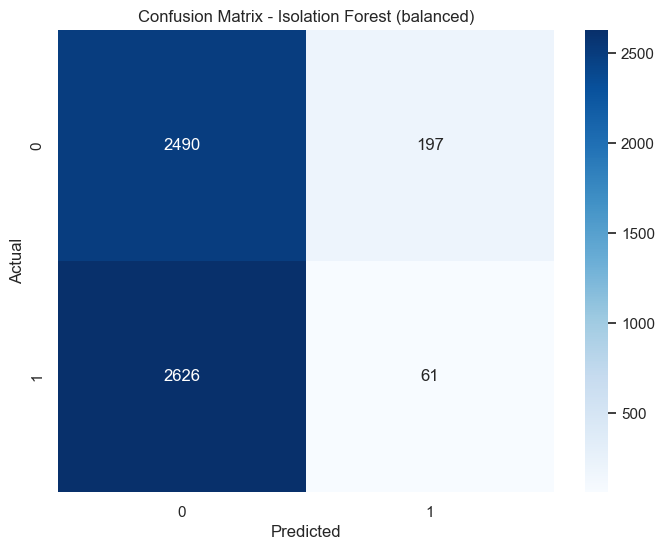

In [341]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test_validation_balanced, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Isolation Forest (balanced)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [342]:
# Make predictions
# Isolation Forest returns 1 for inliers and -1 for outliers, so we need to flip these
X_test_validation, Y_test_validation = X_test.loc[2018].to_numpy(dtype='int'), y_test.loc[2018].to_numpy(dtype='int')
Y_pred = best_model.predict(X_test_validation)
Y_pred = np.where(Y_pred == 1, 0, 1)
acc = accuracy_score(Y_test_validation, Y_pred)
prec = precision_score(Y_test_validation, Y_pred)
rec = recall_score(Y_test_validation, Y_pred)
f1 = f1_score(Y_test_validation, Y_pred)
roc=roc_auc_score(Y_test_validation, Y_pred)

results_of_rs = pd.DataFrame([['Isolation Forest Classifier with PCA and Grid Search', acc,prec,rec, f1, roc]],
                               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC'])

pd.concat([results_logit_gs, results_sgdc_rs,results_xgb_rs, results_of_rs], axis=0, ignore_index=True)

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression with PCA and Grid Search,0.854572,0.047739,0.527778,0.087558,0.693364
1,SGD Classifier with PCA and Grid Search,0.868527,0.074074,0.777778,0.135266,0.823760
2,XGBoost Classifier with PCA and Grid Search,0.821520,0.055336,0.777778,0.103321,0.799942
3,Isolation Forest Classifier with PCA and Grid ...,0.915167,0.010050,0.055556,0.017021,0.491120


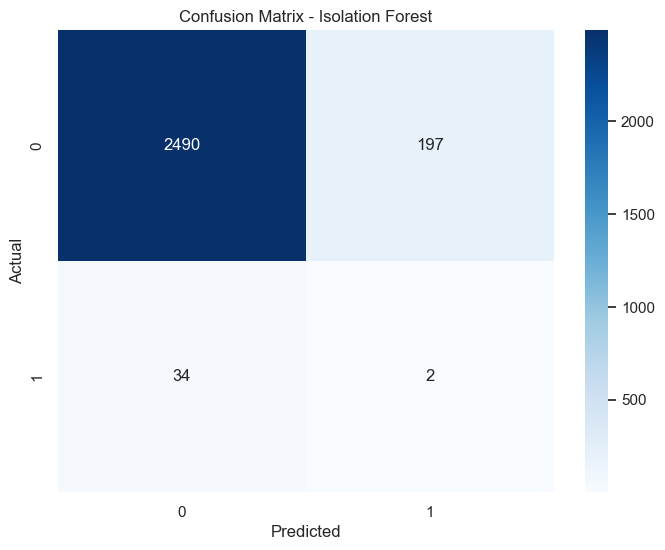

In [343]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test_validation, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Isolation Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Model 5: Random Forest with PCA and Grid search

In [71]:
X = bankruptcy_merged_df_train[features]
y = bankruptcy_merged_df_train['status_label']

importlib.reload(project_helper)

# Define pipeline
def create_pipeline(n_components):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('classifier', RandomForestClassifier( class_weight='balanced', n_jobs=-1,random_state=42,n_estimators=n_components[0],max_depth=n_components[1]))
    ])

# Define range of components to test
configs = project_helper.model_configs([(n_estimators, max_depth)for n_estimators in [100,200,300] for max_depth in range(1,8)  ]) # define the range to grid search on

# Initialize walk-forward validation
wf_validator_rf = project_helper.walk_forward_rolling_train(create_pipeline, X, y)

# Perform grid search
wf_validator_rf.grid_search(configs)

Total configs: 21


 > 0.809
(100, 1) 0.8091844181046532 0.19624709428690124


 > 0.724
(100, 2) 0.7243364879313395 0.280020927920431


 > 0.710
(100, 3) 0.7095561609408836 0.28169895183608007


 > 0.670
(100, 4) 0.6701307926851099 0.28802231426371117


 > 0.632
(100, 5) 0.6324361317673322 0.29228033167422945


 > 0.608
(100, 6) 0.6080219609784773 0.2869445633546741


 > 0.549
(100, 7) 0.5488772636531853 0.32870816178976253


 > 0.813
(200, 1) 0.813011295787709 0.1959000053701868


  0%|          | 0/48 [34:17<?, ?it/s]




 > 0.731
(200, 2) 0.7308233946793388 0.28453925655350554


 > 0.711
(200, 3) 0.7109103486124289 0.27827689824677737


 > 0.670
(200, 4) 0.6698131785128199 0.2863122697399564


 > 0.637
(200, 5) 0.6369603648585975 0.292675601808509


 > 0.571
(200, 6) 0.5705483490276918 0.32551762842409887


 > 0.549
(200, 7) 0.5489931791594238 0.32891388438618857


 > 0.809
(300, 1) 0.8089326419063738 0.19333417879528392


 > 0.732
(300, 2) 0.7320315918684897 0.28066448832861923


 > 0.709
(300, 3) 0.7091344266512475 0.2794988632268031


 > 0.673
(300, 4) 0.6731241703283544 0.2819956363353937


 > 0.644
(300, 5) 0.6437242256206313 0.295659041059321


 > 0.572
(300, 6) 0.5716092746141282 0.31949388510202825




100%|██████████| 21/21 [05:51<00:00, 16.72s/it]

 > 0.550
(300, 7) 0.5501262460720724 0.32929681286423074
done


In [72]:
wf_validator_rf.scores

[{'ModelParam': '(200, 1)',
  'Results': (0.813011295787709, 0.1959000053701868)},
 {'ModelParam': '(100, 1)',
  'Results': (0.8091844181046532, 0.19624709428690124)},
 {'ModelParam': '(300, 1)',
  'Results': (0.8089326419063738, 0.19333417879528392)},
 {'ModelParam': '(300, 2)',
  'Results': (0.7320315918684897, 0.28066448832861923)},
 {'ModelParam': '(200, 2)',
  'Results': (0.7308233946793388, 0.28453925655350554)},
 {'ModelParam': '(100, 2)',
  'Results': (0.7243364879313395, 0.280020927920431)},
 {'ModelParam': '(200, 3)',
  'Results': (0.7109103486124289, 0.27827689824677737)},
 {'ModelParam': '(100, 3)',
  'Results': (0.7095561609408836, 0.28169895183608007)},
 {'ModelParam': '(300, 3)',
  'Results': (0.7091344266512475, 0.2794988632268031)},
 {'ModelParam': '(300, 4)',
  'Results': (0.6731241703283544, 0.2819956363353937)},
 {'ModelParam': '(100, 4)',
  'Results': (0.6701307926851099, 0.28802231426371117)},
 {'ModelParam': '(200, 4)',
  'Results': (0.6698131785128199, 0.2863122

Best model: n_estimators = 200, max_depth = 1, estimated test set recall: 0.81301

In [344]:
X_test = bankruptcy_merged_df_test[features]
y_test = bankruptcy_merged_df_test['status_label']
sm = SMOTE()
X_test_balanced, Y_test_balanced = sm.fit_resample(X=X_test.loc[2016:2018].to_numpy(dtype='int'),y=y_test.loc[2016:2018].to_numpy(dtype='int'))
# Pipeline
steps_rf = [
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=1,random_state=1))
]

pl_rf = Pipeline(steps_rf)
best_model = pl_rf.fit(X_test_balanced,Y_test_balanced)

In [345]:
X_test_validation_balanced, Y_test_validation_balanced = sm.fit_resample(X=X_test.loc[2018].to_numpy(dtype='int'),y=y_test.loc[2018].to_numpy(dtype='int'))
Y_pred = best_model.predict(X_test_validation_balanced)
acc = accuracy_score(Y_test_validation_balanced, Y_pred)
prec = precision_score(Y_test_validation_balanced, Y_pred)
rec = recall_score(Y_test_validation_balanced, Y_pred)
f1 = f1_score(Y_test_validation_balanced, Y_pred)
roc=roc_auc_score(Y_test_validation_balanced, Y_pred)


results_rf_rs_balanced = pd.DataFrame([['Random Forest Classifier with PCA and Grid Search', acc,prec,rec, f1, roc]],
                               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC'])

pd.concat([results_logit_gs_balanced, results_sgdc_rs_balanced, results_xgb_rs_balanced, results_of_rs_balanced, results_rf_rs_balanced], axis=0, ignore_index=True)

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression with PCA and Grid Search,0.775772,0.830804,0.692594,0.755429,0.775772
1,SGD Classifier with PCA and Grid Search,0.864347,0.868322,0.858951,0.863611,0.864347
2,XGBoost Classifier with PCA and Grid Search,0.851507,0.831986,0.880908,0.855748,0.851507
3,Isolation Forest Classifier with PCA and Grid ...,0.474693,0.236434,0.022702,0.041426,0.474693
4,Random Forest Classifier with PCA and Grid Search,0.780052,0.806019,0.737626,0.770307,0.780052


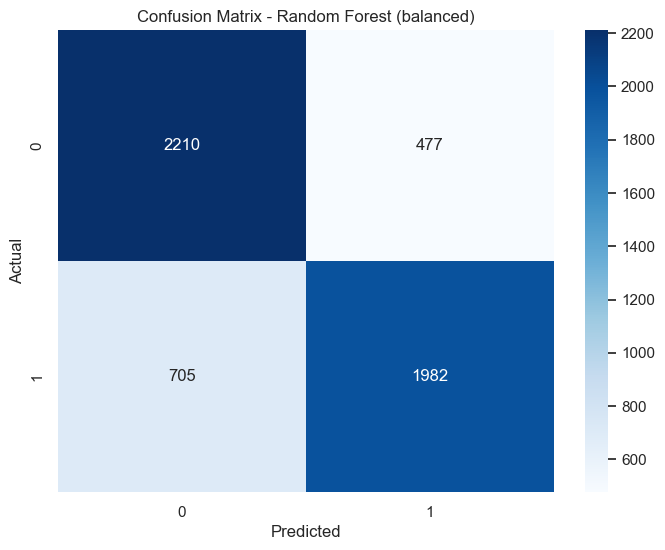

In [346]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test_validation_balanced, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (balanced)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [347]:
# Make predictions
# Isolation Forest returns 1 for inliers and -1 for outliers, so we need to flip these
X_test_validation, Y_test_validation = X_test.loc[2018].to_numpy(dtype='int'), y_test.loc[2018].to_numpy(dtype='int')
Y_pred = best_model.predict(X_test_validation)
acc = accuracy_score(Y_test_validation, Y_pred)
prec = precision_score(Y_test_validation, Y_pred)
rec = recall_score(Y_test_validation, Y_pred)
f1 = f1_score(Y_test_validation, Y_pred)
roc=roc_auc_score(Y_test_validation, Y_pred)

results_rf_rs = pd.DataFrame([['Random Forest Classifier with PCA and Grid Search', acc,prec,rec, f1, roc]],
                               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC'])

pd.concat([results_logit_gs, results_sgdc_rs,results_xgb_rs, results_of_rs,results_rf_rs], axis=0, ignore_index=True)

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression with PCA and Grid Search,0.854572,0.047739,0.527778,0.087558,0.693364
1,SGD Classifier with PCA and Grid Search,0.868527,0.074074,0.777778,0.135266,0.823760
2,XGBoost Classifier with PCA and Grid Search,0.821520,0.055336,0.777778,0.103321,0.799942
3,Isolation Forest Classifier with PCA and Grid ...,0.915167,0.010050,0.055556,0.017021,0.491120
4,Random Forest Classifier with PCA and Grid Search,0.818582,0.038306,0.527778,0.071429,0.675128


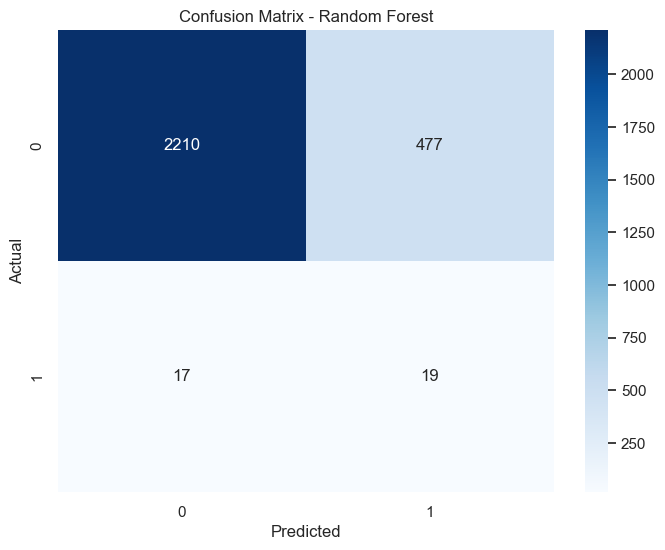

In [348]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(Y_test_validation, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()